In [18]:
##### import codecs
import os
import os.path
import shutil
import string
import sys
import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.error import URLError
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from PIL import Image

#from .utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
from torchvision.datasets.vision import VisionDataset
import pandas as pd

class Facekeypoint(VisionDataset):


    training_file = "training.pt"
    test_file = "test.pt"


    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(
        self,
        root: str = None,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        split : float = 0.2
      
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set
        self.split = split
        self.height=96
        self.width=96
#        print(self.train)
        

        
	
        self.data, self.targets = self._load_data()
 
        

        
    def _load_data(self):
        df_data = pd.read_csv("training.csv")
        #print(df_data.columns)

        # drop all the rows with missing values
        df_data = df_data.dropna()
        len_data = len(df_data)
        # calculate the validation data sample length
        
        valid_split = int(len_data * self.split)
        # calculate the training data samples length
        train_split = int(len_data - valid_split)     
        
        if self.train == True:
            samples = df_data.iloc[:train_split][:]
            samples, keypoints = self.listtoarray(samples)
            print(f"Training sample instances: {len(samples)}")
        elif self.train == False:
            samples = df_data.iloc[-valid_split:][:]
            samples, keypoints = self.listtoarray(samples)
            print(f"Validation sample instances: {len(samples)}")
                
        return samples, keypoints
    
    def listtoarray(self, samples):
        #store the pixel values after extracting them from the Image column
        image_pixels = []
        keypoints =[]
        for i in tqdm(range(len(samples))):
            #pixel values by space as they are space separated in the CSV file as well
            img = samples.Image.iloc[i].split(' ')
            image_pixels.append(img)
            keypoints.append(samples.iloc[i][:30].tolist())
        #images = np.array(image_pixels, dtype='float32')
        #keypoints = np.array(keypoints, dtype='float32')
        # reshape the keypoints
        #keypoints = keypoints.reshape(-1, 2)
      
       
        
        #return images,keypoints
        return image_pixels,keypoints
       
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]
        img =np.array(img, dtype='uint8').reshape(self.height,self.width)
        img = torch.Tensor(img)
        img = img[None,:]
        target = torch.Tensor(target)/96
        

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target



    def __len__(self) -> int:
        return len(self.data)
    
    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "processed")

    @property
    def class_to_idx(self) -> Dict[str, int]:
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self) -> bool:
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = f"{mirror}{filename}"
                try:
                    print(f"Downloading {url}")
                    download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)
                except URLError as error:
                    print(f"Failed to download (trying next):\n{error}")
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError(f"Error downloading {filename}")

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

    # get the training and validation data samples
print('\n-------------- PREPARING DATA --------------\n')
train_data=Facekeypoint(train = True)
valid_data = Facekeypoint(train = False)

print('\n-------------- DATA PREPRATION DONE --------------\n')
    # prepare data loaders
train_loader = DataLoader(train_data,
                              batch_size=256,
                              shuffle=True)
valid_loader = DataLoader(valid_data,
                              batch_size=256,
                              shuffle=False)


-------------- PREPARING DATA --------------



100%|██████████| 1712/1712 [00:10<00:00, 161.34it/s] 


Training sample instances: 1712


100%|██████████| 428/428 [00:00<00:00, 1234.63it/s]


Validation sample instances: 428

-------------- DATA PREPRATION DONE --------------



In [19]:
OUTPUT_PATH = '/home/nandhini/NandhiniMathivananRnD/outputs'

BATCH_SIZE = 256
LR = 0.0001
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#train test split
TEST_SPLIT = 0.2
SHOW_DATASET_PLOT = True

In [20]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import os
import torch
from copy import deepcopy

class FaceKeypointModel(nn.Module):
    def __init__(self, freeze_resnet = False):
        super(FaceKeypointModel, self).__init__()
        
        # Convert 1 filter 3 filter because resnet accepts 3 filter only
        self.conv1 = nn.Conv2d( in_channels=1, out_channels=3, kernel_size=(3, 3), stride=1, padding=1, padding_mode='zeros' )
        
        # Resnet Architecture
        self.resnet18 = models.resnet18(pretrained=True)
        if freeze_resnet:
            for param in self.resnet18.parameters():
                param.requires_grad = False
        # replacing last layer of resnet
        # by default requires_grad in a layer is True
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 384) 

        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(384, 30) 
        self.variance = nn.Linear(384,30) 
        
    def forward(self, x):
        y0 = self.conv1(x)
        y1 = self.resnet18(y0)
        y_relu = self.relu(y1)
        out= self.linear1(y_relu)
        scale = F.softplus(self.variance(y_relu))
        return out,scale

In [21]:
def CauchyNLLLoss(input, target, scale, eps=1e-06, reduction='mean'):

    # Inputs and targets much have same shape
    input = input.view(input.size(0), -1)
    target = target.view(target.size(0), -1)
    if input.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of scale must match that of input or be equal to 1
    scale = scale.view(input.size(0), -1)
    if scale.size(1) != input.size(1) and scale.size(1) != 1:
        raise ValueError("scale is of incorrect size")

    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(scale < 0):
        raise ValueError("scale has negative entry/entries")

    # Clamp for stability
    scale = scale.clone()
    with torch.no_grad():
        scale.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = (torch.log(3.14*scale) + torch.log(1 + ((input - target)**2)/scale**2)) .view(input.size(0), -1).sum(dim=1)


    # Apply reduction
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss



In [22]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib
from tqdm import tqdm
matplotlib.style.use('ggplot')
import argparse
import numpy as np


model = FaceKeypointModel().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)



def validate(model, dataloader, data, epoch):
    print('Validating')
  
    valid_running_loss = 0.0
    val_difference = []
    Scale = []
  

    with torch.no_grad():
        for i, [image,keypoints] in tqdm(enumerate(valid_loader)):
            
            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)
        
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs,scale = model(image)
            loss = CauchyNLLLoss(outputs, keypoints,scale)
            valid_running_loss += loss.item()
            val_difference.extend(abs(keypoints - outputs).squeeze(1).tolist())
            
 
    diff = np.average(val_difference)    
    valid_loss = np.average(valid_running_loss)
    avg_scale  = np.average(Scale)  
    return valid_loss,diff,avg_scale




In [ ]:
def train_func():
    last_loss = 10000
    patience = 5
    triggertimes = 0
    model_save_loc = "/home/nandhini/NandhiniMathivananRnD/outputs/nc_model.pth"
    print('Training')
    Train_epoch_loss = []
    Val_epoch_loss = []
    for e in range(EPOCHS):
    
        model.train()
        train_running_loss = 0.0
        counter = 0

        
       
        for i, [image,keypoints] in tqdm(enumerate(train_loader)):
            counter += 1     
         
            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)
            keypoints = keypoints.view(keypoints.size(0), -1)
            optimizer.zero_grad()
            outputs,scale = model(image)
            loss = CauchyNLLLoss(outputs, keypoints,scale)
            train_running_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        train_loss = np.average(train_running_loss)
        Train_epoch_loss.append(train_loss)
        model.eval()
        
        with torch.no_grad():
            
            validation_loss = validate(model, valid_loader, valid_data, e)
            val_loss = validation_loss[0]
            pred = validation_loss[1]
            Val_epoch_loss.append(val_loss)
            
        print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Validation Loss: {:.3f}.. ".format(val_loss))

        current_loss = val_loss
        print('The Current Loss:', current_loss)
        
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times, '\n')
            
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
            
        else:
            print('trigger times: 0', '\n')
            trigger_times = 0
            torch.save(model, model_save_loc)
            
        last_loss = current_loss
        model.train()
                                     
        
    plt.figure(figsize=(10, 7))
    plt.plot(Train_epoch_loss, color='orange', label='train loss')
    plt.plot(Val_epoch_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/home/nandhini/NandhiniMathivananRnD/outputs/nc_loss.png')
    plt.show()

    print('DONE TRAINING')
                                     
    return model,Val_epoch_loss, Train_epoch_loss
                                     
                                     
                                     
                
    
    

In [ ]:
face_model,valid_loss, training_loss = train_func()

In [23]:
import scipy.stats 

def test_validation(model, valid_loader):
    
    model.eval()
#     model.to('cuda')
   
    val_difference =[]
    pred_x = []
    pred_y = [] 
    true_x = []
    true_y = []
    sca_x = []
    sca_y = []
    img = []
    ent = []
    vald = []

    with torch.no_grad():
        for i, [image,keypoints] in tqdm(enumerate(valid_loader)):

            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)

            keypoints = keypoints.view(keypoints.size(0), -1)

            key_x = [[keypoints[j][i].item() for i in range(len(keypoints[0])) if i%2 == 0] for j in range(len(keypoints))]
            key_y = [[keypoints[j][i].item() for i in range(len(keypoints[0])) if i%2 != 0] for j in range(len(keypoints))]
            true_x.extend(key_x)
            true_y.extend(key_y)

            
            outputs,scale = model(image)
            out_x = [[outputs[j][i].item() for i in range(len(outputs[0])) if i%2 == 0] for j in range(len(outputs))]
            out_y = [[outputs[j][i].item() for i in range(len(outputs[0])) if i%2 != 0] for j in range(len(outputs))]
            pred_x.extend(out_x)
            pred_y.extend(out_y)
            
            s_x = [[scale[j][i].item() for i in range(len(scale[0])) if i%2 == 0] for j in range(len(scale))]
            s_y = [[scale[j][i].item() for i in range(len(scale[0])) if i%2 != 0] for j in range(len(scale))]
            sca_x.extend(s_x)
            sca_y.extend(s_y)
            
            loss = CauchyNLLLoss(outputs, keypoints,scale)
            en = scipy.stats.cauchy(loc=outputs, scale=scale).entropy()
            
            ent.extend(np.average(en, axis = 1))
           

            img.extend(image.numpy())
       
            val = (abs(keypoints - outputs).squeeze(1).tolist())
            vald.extend(np.average(val, axis = 1))

    
    return ent, vald ,pred_x,pred_y, sca_x, sca_y ,true_x, true_y, img

In [24]:
import torch
val_model = torch.load("/home/nandhini/NandhiniMathivananRnD/src/normal_01/cauchy/nc_model.pth")
ent, vald ,pred_x,pred_y, sca_x, sca_y ,true_x, true_y, img = test_validation(val_model, valid_loader)

2it [00:03,  1.92s/it]


In [25]:
final1 = pd.DataFrame(columns=['image_label', 'keypoints','entropy', 'Val diff','true_value_x','true_value_y','predicted_value_x','predicted_value_y','scale_x','scale_y', 'pixel_value'])

for i in range(len(img)):
    for j in range(len(pred_x[i])):
        dictionary = pd.Series(data = {
        'image_label': i+1 ,
        'keypoints' : j+1 ,
        'entropy' : ent[i],
        'Val diff' : vald[i],
        'true_value_x' : true_x[i][j],
        'true_value_y' : true_y[i][j],
        'predicted_value_x' :  pred_x[i][j] ,
        'predicted_value_y' :  pred_y[i][j] ,
        'scale_x' : sca_x[i][j],
        'scale_y' : sca_y[i][j],
        'pixel_value' : img [i]
        })

        final1 = final1.append(dictionary , ignore_index = True)

In [26]:
final1

,image_label,keypoints,entropy,Val diff,true_value_x,true_value_y,predicted_value_x,predicted_value_y,scale_x,scale_y,pixel_value
0,1,1,-2.528967,0.012114,0.696891,0.358050,0.690171,0.374271,0.005970,0.005306,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
1,1,2,-2.528967,0.012114,0.313758,0.380679,0.307023,0.397902,0.006324,0.006610,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
2,1,3,-2.528967,0.012114,0.589089,0.388794,0.600818,0.401698,0.008491,0.005855,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
3,1,4,-2.528967,0.012114,0.772322,0.358700,0.767074,0.375807,0.006525,0.007068,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
4,1,5,-2.528967,0.012114,0.402516,0.404026,0.396679,0.390039,0.004576,0.003968,"[[[22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 2..."
...,...,...,...,...,...,...,...,...,...,...,...
6415,428,11,-2.589819,0.013626,0.520561,0.617389,0.508687,0.605204,0.004563,0.007996,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
6416,428,12,-2.589819,0.013626,0.756254,0.748563,0.732465,0.751085,0.005236,0.008522,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
6417,428,13,-2.589819,0.013626,0.356591,0.805619,0.346152,0.799791,0.004485,0.005461,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."
6418,428,14,-2.589819,0.013626,0.537494,0.791287,0.532344,0.779035,0.006181,0.007098,"[[[68.0, 19.0, 19.0, 23.0, 19.0, 26.0, 23.0, 1..."


In [30]:
final2 = final1.sort_values('Val diff').reset_index(drop=True)
final3 = final2.tail(75).reset_index(drop=True)
final3

,image_label,keypoints,entropy,Val diff,true_value_x,true_value_y,predicted_value_x,predicted_value_y,scale_x,scale_y,pixel_value
0,379,6,-2.46410,0.050912,0.297731,0.372719,0.265819,0.370323,0.008642,0.005300,"[[[6.0, 3.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0..."
1,379,4,-2.46410,0.050912,0.818707,0.385924,0.772933,0.372089,0.007139,0.007433,"[[[6.0, 3.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0..."
2,379,5,-2.46410,0.050912,0.440117,0.380086,0.385648,0.371953,0.004837,0.004307,"[[[6.0, 3.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0..."
3,379,3,-2.46410,0.050912,0.654659,0.392643,0.609759,0.383468,0.009367,0.006126,"[[[6.0, 3.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0..."
4,379,7,-2.46410,0.050912,0.611383,0.247490,0.549460,0.299956,0.008216,0.007456,"[[[6.0, 3.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...
70,321,12,-2.54005,0.077134,0.456974,0.630506,0.627950,0.733472,0.005302,0.008470,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."
71,321,13,-2.54005,0.077134,0.277326,0.590523,0.344260,0.732473,0.005056,0.005407,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."
72,321,15,-2.54005,0.077134,0.344246,0.596170,0.495405,0.793684,0.008570,0.007624,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."
73,321,8,-2.54005,0.077134,0.654834,0.348277,0.796552,0.318963,0.006271,0.005211,"[[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0..."


/home/nandhini/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(1, 29657)
(14840, 1)
(14817, 1)
14817


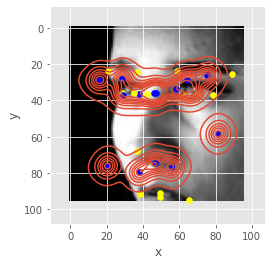

/home/nandhini/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(1, 59332)
(29684, 1)
(29648, 1)
29648


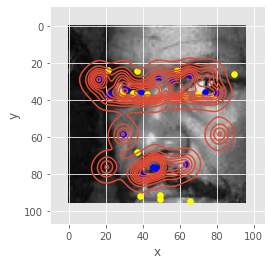

/home/nandhini/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(1, 88992)
(44526, 1)
(44466, 1)
44466


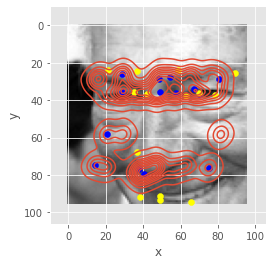

/home/nandhini/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(1, 118655)
(59338, 1)
(59317, 1)
59317


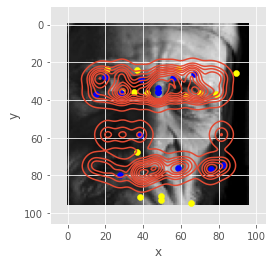

/home/nandhini/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


(1, 148311)
(74167, 1)
(74144, 1)
74144


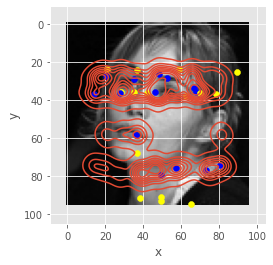

IndexError: single positional indexer is out-of-bounds

In [31]:
import seaborn as sns
import scipy.stats as stats
import itertools

x = np.array([])
y = np.array([])
for img_id in range(75):
    img = final3['pixel_value'].iloc[15*img_id]
    img = img.squeeze(0)
    plt.imshow(img, cmap="gray")
    for i,pred_x in enumerate(final2[ 'predicted_value_x'][15*img_id : 15*(img_id+1)].to_list()):
        pred_y = final3['predicted_value_y'].iloc[i]
        scale_x =  final3['scale_x'].iloc[i]
        scale_y =  final3['scale_y'].iloc[i]
        true_x = final3['true_value_x'].iloc[i]
        true_y = final3['true_value_y'].iloc[i]
        data_x = stats.cauchy.rvs(loc=pred_x*96, scale=scale_x*96, size=1000)  # draw 1000 samples
        data_y = stats.cauchy.rvs(loc=pred_y*96, scale=scale_y*96, size=1000)  # draw 1000 samples
        data_x = data_x[(data_x >= 0) & (data_x <= 96)]
        data_y = data_y[(data_y >= 0) & (data_y <= 96)]
        plt.scatter(pred_x*96,pred_y*96, c='Blue', marker='o')
        plt.scatter(true_x*96,true_y*96, c='yellow', marker='o')

        
        

        x = np.append(x,data_x)
        y = np.append(y,data_y)
    

    data = np.column_stack((itertools.zip_longest([x,y], fillvalue=0)))
    print (data.shape)
    
    x = np.expand_dims(x, axis=1)
    print (x.shape)
    
    y = np.expand_dims(y, axis=1)
    print (y.shape)
    
    min_size = x.shape[0] if x.shape[0] < y.shape[0] else y.shape[0]
    
    print (min_size)
    

    data = pd.DataFrame(data=np.column_stack((x[:min_size,:],y[:min_size,:])), columns=['x','y'])
    
    hmax = sns.kdeplot(data=data, x="x", y="y")
    hmax.collections[0].set_alpha(0)
    plt.savefig('/home/nandhini/NandhiniMathivananRnD/src/normal_01/cauchy/most_error/test' + str(img_id))
   
    plt.show()

        

In [ ]:
keypoints = np.array([(150,150), (290,150)])
scales = np.array([(1,2), (0.5,1)])

x = np.array([])
y = np.array([])
for keypoint, scale in zip(keypoints,scales):
    keypoint_x, keypoint_y = keypoint
    scale_x, scale_y = scale

    data_x = stats.cauchy.rvs(loc=keypoint_x, scale=scale_x, size=100)  # draw 1000 samples
    data_y = stats.cauchy.rvs(loc=keypoint_y, scale=scale_y, size=100)  # draw 1000 samples


    x = np.append(x,data_x)
    
    y = np.append(y,data_y)

x = np.expand_dims(x, axis=1)

y = np.expand_dims(y, axis=1)

print (x.shape)
data = pd.DataFrame(data=np.column_stack((x,y)), columns=['x','y'])
sns.kdeplot(data=data, x="x", y="y")

In [ ]:
import matplotlib.pyplot as plt
img = final1['pixel_value'][0][0]
print(img.size)
key_x = final1['predicted_value_x'][0:15]
key_y = final1['predicted_value_y'][0:15]
true_x = final1['true_value_x'][0:15]
true_y = final1['true_value_y'][0:15]
#print(key_x)
#print(key_y)

#print(key)
plt.imshow(img, cmap="gray")
plt.scatter(key_x*96,key_y*96, c='Red', marker='*')
plt.scatter(true_x*96,true_y*96, c='Green', marker='*')
plt.savefig('/home/nandhini/NandhiniMathivananRnD/src/normal_01/cauchy/face_cauchy.png')

In [ ]:
import scipy.stats 

def test_validation(model, valid_loader):
    
    model.eval()
#     model.to('cuda')
   
    val_difference =[]
    ent = []
    out = []
    sca = []
    key = []
    img = []
    
    with torch.no_grad():
        for i, [image,keypoints] in tqdm(enumerate(valid_loader)):
            
            image, keypoints = image.to(DEVICE), keypoints.to(DEVICE)
        
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs,scale = model(image)
            loss = CauchyNLLLoss(outputs, keypoints,scale)
            #en = ent.extend(scipy.stats.laplace(loc=outputs, scale=scale).entropy())
            #print(scale)
            out.extend(outputs.numpy().tolist())
            sca.extend(scale.numpy())
            img.extend(image.numpy())
            key.extend(keypoints.numpy())
            val_difference.extend(abs(keypoints - outputs).squeeze(1).tolist())
 

    
    return out, sca ,key ,img,val_difference
    

In [ ]:
import torch
val_model = torch.load("/home/nandhini/NandhiniMathivananRnD/outputs/nc_model.pth")
out, sca ,key ,img,val_difference = test_validation(val_model, valid_loader)

In [ ]:
import pandas as pd
vald_results = pd.DataFrame(val_difference, columns=[str(i) for i in range(30)])
vald_results['exp_name'] = 'cauchy'
vald_results.to_csv('ncf.csv')


In [ ]:
final = pd.DataFrame(columns=['image_label', 'keypoints','true_value','predicted_value','scale', 'val_difference','pixel_value'])

for i in range(len(img)):
    for j in range(len(sca[i])):
        dictionary = pd.Series(data = {
        'image_label': i+1 ,
        'keypoints' : j+1 ,
        'true_value' : key[i][j],
        'predicted_value' :  out[i][j] ,
        'scale' : sca[i][j],
        'val_difference' : val_difference[i][j],
        'pixel_value' : img [i]
        })

        final = final.append(dictionary , ignore_index = True)

In [ ]:
final

In [ ]:
import uncertainty_toolbox as uct
    
predictions = final['predicted_value'].to_numpy()
print(type(predictions))

predictions_std = np.sqrt(final['scale'].to_numpy())

Y_true = final['true_value'].to_numpy()
#Y_true = Y_true.flatten()

metrics = uct.metrics.get_all_metrics(predictions, predictions_std, Y_true)

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.set_style('white')
sns.boxplot( data=vald_results, ax = ax, width=0.8)
sns.boxplot( data=vald_results)
plt.savefig('ncf.png')

In [ ]:
val_model = torch.load("/home/nandhini/NandhiniMathivananRnD/outputs/nl_model.pth")
vald_out, lap_scale = test_validation(val_model, valid_loader)

In [ ]:
import pandas as pd
b = pd.DataFrame(vald_out)
std = pd.DataFrame(lap_ent)

#vald_results['exp_name'] = 'laplace'
b.to_csv('b.csv')
std.to_csv('std.csv')